## 1. Data Exploration



In [25]:
import sys
import os
import pandas as pd
import numpy as np
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from src.data_utils import get_final_ds

dataset = get_final_ds()


Data exists at path: /Users/yassinkina/Desktop/Github/portfolio/review_sentiment_analysis/data/datasets, loading data...


Ensure there are no empty values within each of the data splits. We will focus most of our analysis on `df_train`, but it is still crucial to not assume that our data is clean.

In [52]:
df_train = pd.DataFrame.from_dict(dataset["train"])
df_val = pd.DataFrame.from_dict(dataset["validation"])
df_test = pd.DataFrame.from_dict(dataset["test"])

print(df_train.isna().values.any())
print(df_val.isna().values.any())
print(df_test.isna().values.any())


False
False
False


Here we can see that more than half of the reviews are 5 stars and that 1, 2, and 3 star ratings make up less than 25% of the data.

In [29]:
df_train.describe()

,rating,timestamp,helpful_vote
count,10000.000000,1.000000e+04,10000.000000
mean,4.108500,1.552776e+12,1.017000
std,1.315941,7.819591e+10,5.833996
min,1.000000,1.050088e+12,0.000000
25%,4.000000,1.495931e+12,0.000000
50%,5.000000,1.570662e+12,0.000000
75%,5.000000,1.612363e+12,1.000000
max,5.000000,1.679133e+12,430.000000


### Skewed Data
With a bar graph we can even more clearly see how skewed the data is. We can plot each of the dataset splits to ensure that every label is represented in each split.

In [48]:
import matplotlib.pyplot as plt

def plot_star_rating_counts(df, title):
    counts_per_rating = df["rating"].value_counts().sort_index()
    color = ["blue" if title == "Train" else "orange" if title == "Validation" else "green"]
    plt.bar(x=counts_per_rating.index, height=counts_per_rating.values, color=color)
    plt.xlabel("Star Rating")
    plt.ylabel("Number of Reviews")
    plt.title(f"Number of Customer Reviews per Star Rating: {title} ")
    

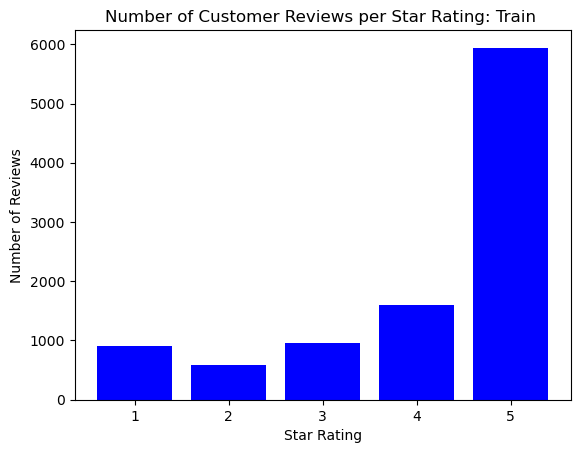

In [43]:
plot_star_rating_counts(df_train, "Train")

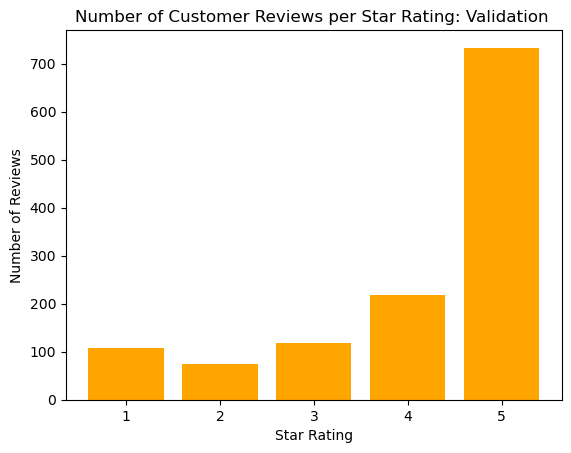

In [45]:
plot_star_rating_counts(df_val, "Validation")

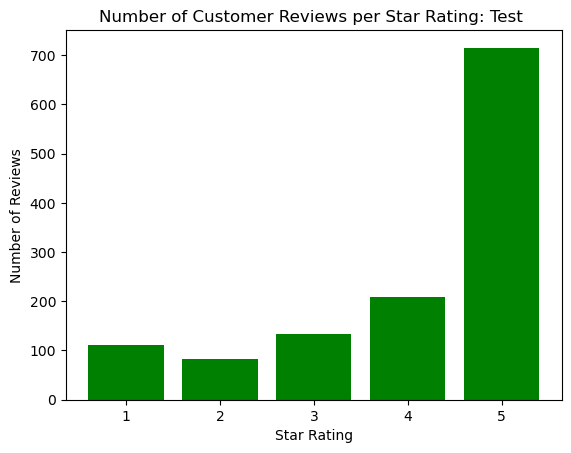

In [47]:
plot_star_rating_counts(df_test, "Test")

## 2. Review Length Analysis
Understanding the length of reviews is crucial for selecting model parameters (like max sequence length).

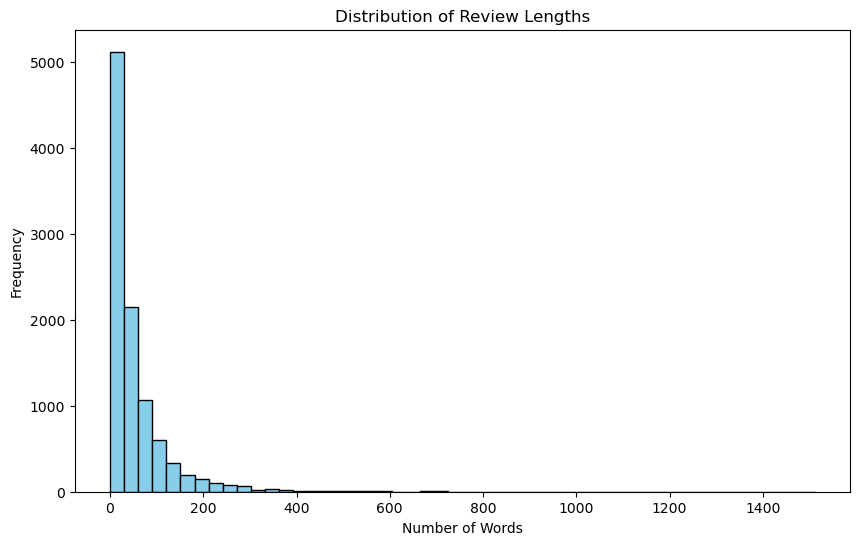

count    10000.000000
mean        53.165600
std         73.754774
min          0.000000
25%         11.000000
50%         29.000000
75%         65.000000
max       1511.000000
Name: review_length, dtype: float64


In [ ]:
# Calculate review length (number of words)
df_train['review_length'] = df_train['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
plt.hist(df_train['review_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Customer Review Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

print(df_train['review_length'].describe())

## 3. Temporal Analysis
Checking how the number of reviews changes over time.

/var/folders/24/5y8ykfh1335dq604_v6rws5c0000gn/T/ipykernel_7702/3872363991.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  reviews_over_time = df_train.set_index('date').resample('M').size()


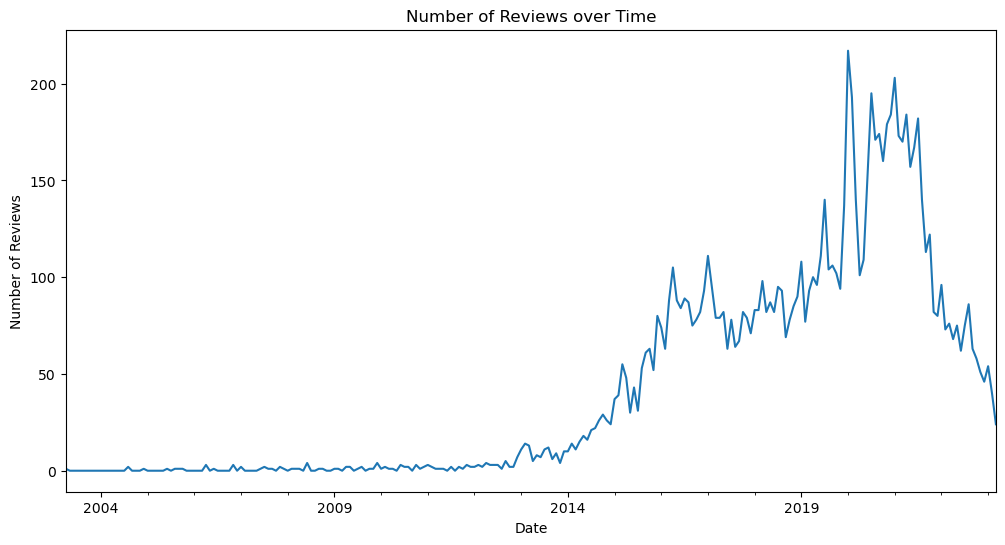

In [53]:
df_train['date'] = pd.to_datetime(df_train['timestamp'], unit='ms')
reviews_over_time = df_train.set_index('date').resample('M').size()

plt.figure(figsize=(12, 6))
reviews_over_time.plot()
plt.title('Number of Reviews over Time')
plt.xlabel('Date')
plt.ylabel('Number of Reviews')
plt.show()

## 4. Initial Conclusions
Given that the number of 5 star reviews is significantly higher than the other star ratings, we must take this into account when evaluating our model's performance. More specifically, `Accuracy` will not be a useful metric because the skewed 5 star ratings may cause the model to learn to guess 5 stars 100% of the time, which would provide us with a misleading and inaccurate understanding as to how well the model actually peforms. 

To mitigate this, we will use `F1 Score` as the primary metric of our model's performance. Given that there are only 5 classes (each of the star ratings), a Confusion Matrix will be an effective way to visualize how well the model actually performs, so we will discuss `Precision` and `Recall` as well.